In [2]:
from trainer.classification import Trainer
from trainer.attention_approx import Trainer as ApproxTrainer
import models.sparse_token as sparse
import importlib

In [3]:
batch_size= 8 
device = 1
factor = 16

trainer = Trainer(device=device, batch_size=batch_size, model='bert-mini')
trainer.model.eval()
trainer.load()
bert = trainer.model.bert
fc = trainer.model.classifier
batch = trainer.get_batch().to(device)
test_batch = trainer.get_batch(test=True).to(device)

approx_trainer = ApproxTrainer(model=trainer.model_type, device=trainer.device, batch_size=batch_size, factor=factor)
approx_trainer.bert.eval()
approx_trainer.load()
approx_bert = approx_trainer.bert

100%|██████████| 7600/7600 [00:00<00:00, 194877.58it/s]


Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:1012, avg_len:236.477525, count:120000
Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:892, avg_len:235.2992105263158, count:7600


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainer.__init__: Model initialized. model = bert-mini
Trainer.load: Loading... saves/cls_bert-mini.pth


100%|██████████| 7600/7600 [00:00<00:00, 143395.01it/s]


Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:1012, avg_len:236.477525, count:120000
Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:892, avg_len:235.2992105263158, count:7600


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainer.__init__: Model initialized. model = bert-mini
Trainer.load: Loading... saves/cls_bert-mini.pth
Trainer.load: saves/att_approx_16_bert-mini.pth


In [4]:
import importlib
importlib.reload(sparse)
sparse_bert = sparse.SparseBertModel(bert.config)
sparse_bert.to(trainer.device)
sparse_bert.eval()
sparse_bert.load_state_dict(bert.state_dict())
sparse.set_print(sparse_bert, False)

In [5]:
bert_args = {
    'input_ids':test_batch.input_ids,
    'attention_mask':test_batch.attention_masks,
    'output_attentions':True,
}
att_bert = bert(**bert_args).attentions
att_approx = approx_bert(**bert_args).attentions
att_sparse = sparse.run_bert_with_approx(sparse_bert, approx_bert, bert_args, ks=[0.25] * len(bert.encoder.layer)).attentions

bert-mini


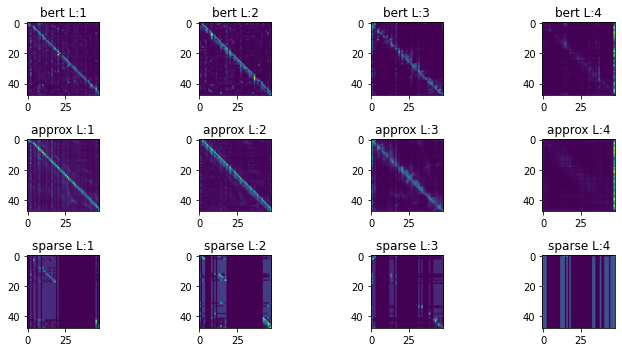

In [6]:
import matplotlib.pyplot as plt
import torch

plt.rcParams['figure.figsize'] = [10, 5]

LAYERS = len(att_bert)
BATCH_IDX = 0

def plot_grid(tensor): plt.imshow(tensor.cpu().detach().numpy())
def plot_att(atts, idx=0, count=3):
    N = int(torch.sum(test_batch.attention_masks[BATCH_IDX]).item())
    for i, att in enumerate(atts):
        plt.subplot(3, LAYERS, idx*LAYERS + i+1)
        name = ['bert','approx','sparse'][idx]
        plt.title(f'{name} L:{i+1}')
        plot_grid(torch.sum(att[BATCH_IDX], dim=0)[:N, :N])
print(trainer.model_type)
plot_att(att_bert, idx=0)
plot_att(att_approx, idx=1)
plot_att(att_sparse, idx=2)
plt.tight_layout()
plt.show()